In [1]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
import scipy.misc

/Users/nashmasamba/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class player:
    def __init__(self, img_size, num_actions):
        self.img_size = img_size
        self.num_actions = num_actions
        self.q_table = deque(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.buildCNN()
        
    def buildCNN(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(5,5), input_shape=(64,64,1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(28, activation='relu'))
        # Output layer with two nodes representing Left and Right cart movements
        model.add(Dense(self.num_actions, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def write_state(self, state, action, rewardm, next_state, done):
        self.q_table.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.num_actions)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.q_table, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [3]:
# How many times to play the game
EPISODES = 50

In [4]:
def rgb2gray(rgb):
    r,g,b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

def shapeState(img):
    # resize image and make grayscale
    resized_gray = rgb2gray(scipy.misc.imresize(img,(64,64)))/ 255.0
    shaped = resized_gray.reshape(1,64,64,1)
    return shaped

In [5]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


def display_frames_as_gif(frames):
    # Displays a list of frames as a gif, with controls
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [6]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
# feed 64 by 64 grayscale images into CNN
state_size = (64,64)
action_size = env.action_space.n
agent = player(state_size, action_size)
done = False
batch_size = 32

max_score = 0
frames = []
best = []

for e in range(EPISODES):
    frames = []
    state = env.reset()
    state = env.render(mode='rgb_array')
    state = shapeState(state)
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        pix  = env.render(mode='rgb_array')
        frames.append(pix)
        next_state = shapeState(pix)
        reward = reward if not done else -10
        agent.write_state(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            if time > max_score:
                max_score = time
                best = frames
            break
    if len(agent.q_table) > batch_size:
        agent.replay(batch_size)
        
print("Best Score: {}".format(max_score))

/Users/nashmasamba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


episode: 0/50, score: 36, e: 1.0
episode: 1/50, score: 30, e: 0.99
episode: 2/50, score: 16, e: 0.99
episode: 3/50, score: 10, e: 0.99
episode: 4/50, score: 21, e: 0.98
episode: 5/50, score: 18, e: 0.98
episode: 6/50, score: 32, e: 0.97
episode: 7/50, score: 27, e: 0.97
episode: 8/50, score: 10, e: 0.96
episode: 9/50, score: 32, e: 0.96
episode: 10/50, score: 23, e: 0.95
episode: 11/50, score: 10, e: 0.95
episode: 12/50, score: 36, e: 0.94
episode: 13/50, score: 16, e: 0.94
episode: 14/50, score: 40, e: 0.93
episode: 15/50, score: 37, e: 0.93
episode: 16/50, score: 44, e: 0.92
episode: 17/50, score: 22, e: 0.92
episode: 18/50, score: 10, e: 0.91
episode: 19/50, score: 24, e: 0.91
episode: 20/50, score: 28, e: 0.9
episode: 21/50, score: 15, e: 0.9
episode: 22/50, score: 12, e: 0.9
episode: 23/50, score: 18, e: 0.89
episode: 24/50, score: 11, e: 0.89
episode: 25/50, score: 27, e: 0.88
episode: 26/50, score: 16, e: 0.88
episode: 27/50, score: 25, e: 0.87
episode: 28/50, score: 35, e: 0.87

While the convolutional network improves its performance over time, a score of 200 or better is typically considered "beating" CartPole. There is certainly room for improvement here. What this exercise impressed upon me is that training CNNs requires a lot more time and compute power than vanilla neural networks. That said, making this network deeper and tweaking the hyperparameters is almost certainly the key for making this network score 200 or above on CartPole.

In [7]:
import imageio
imageio.mimsave("best.gif", best, 'GIF', duration=0.05)


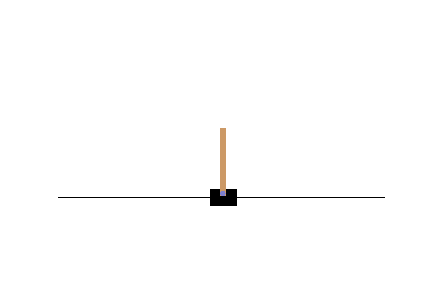
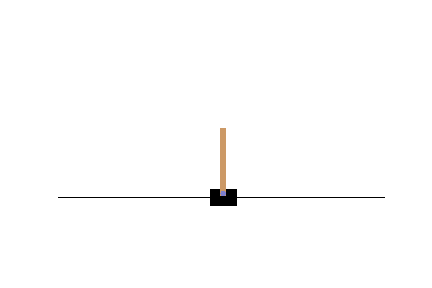
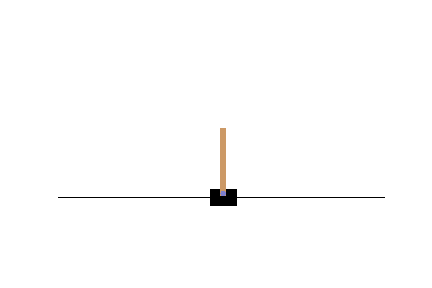
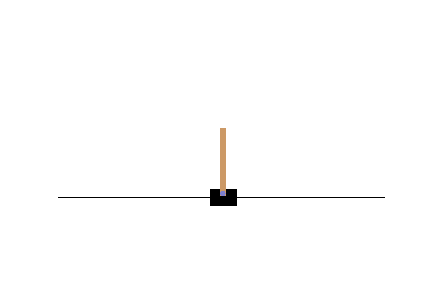
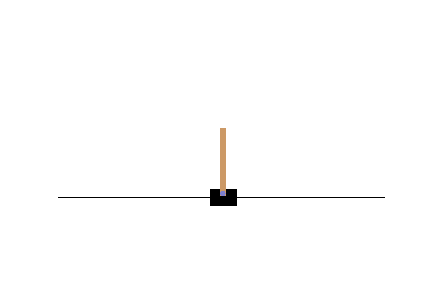
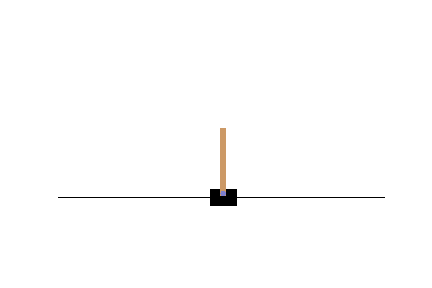
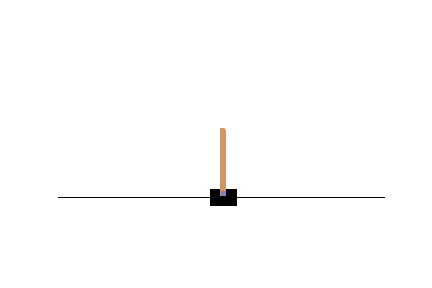
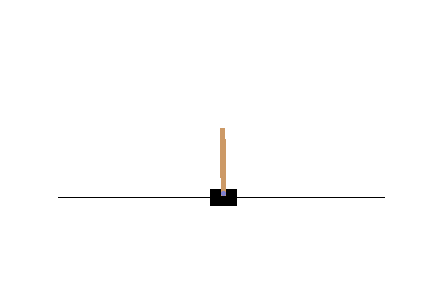
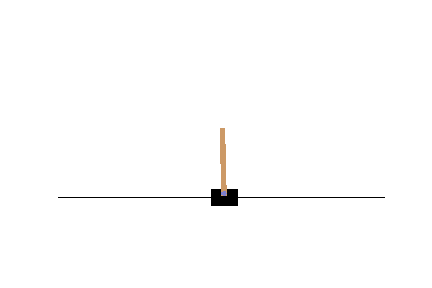
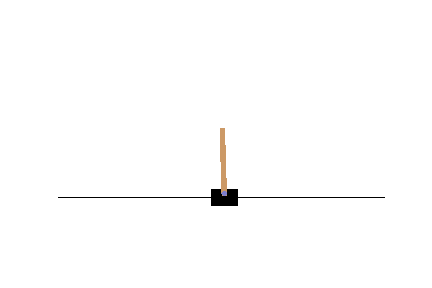
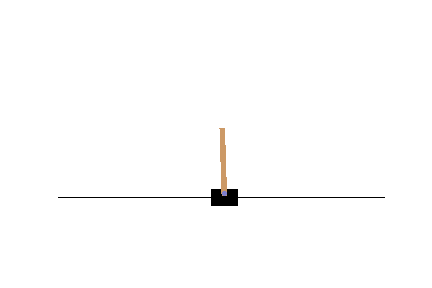
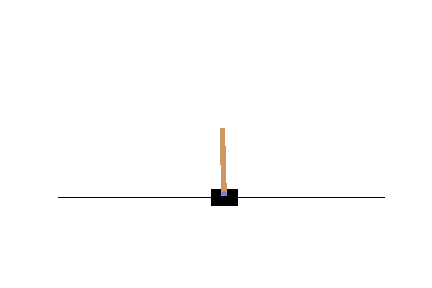
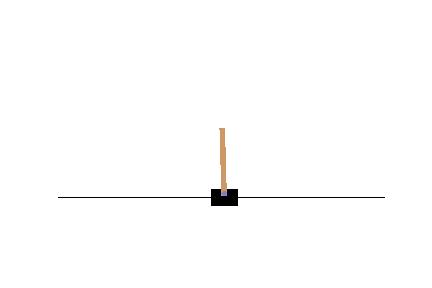
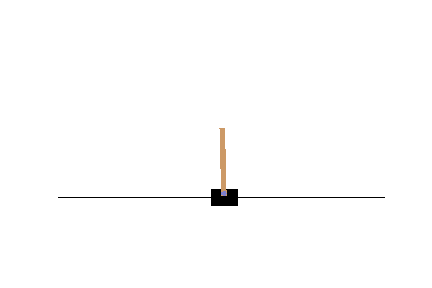
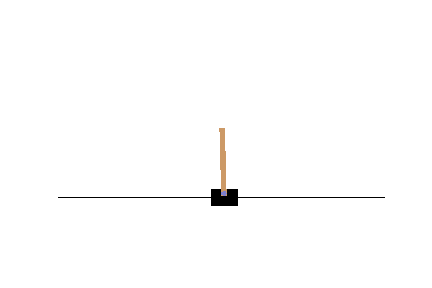
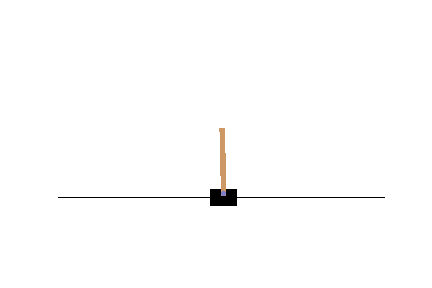
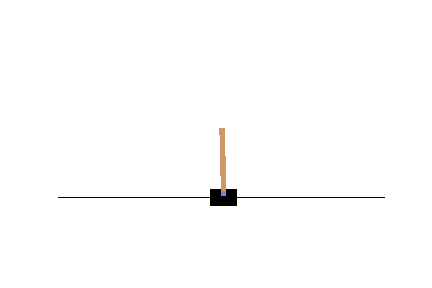
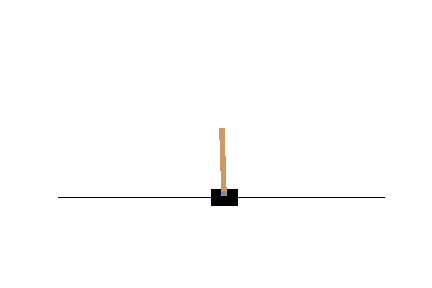
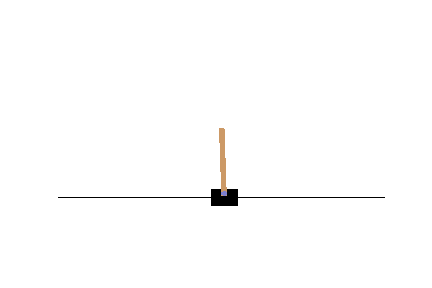
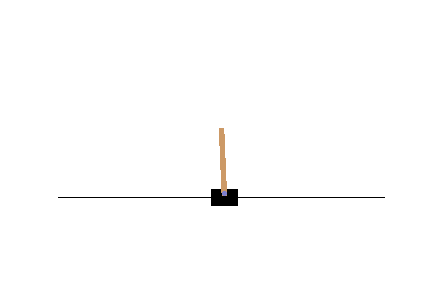
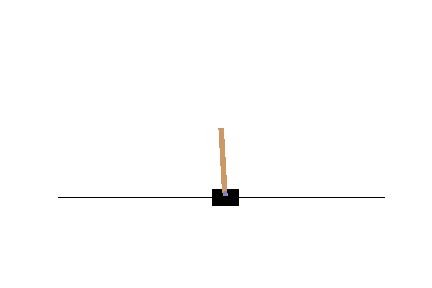
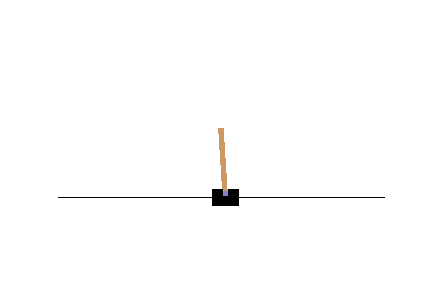
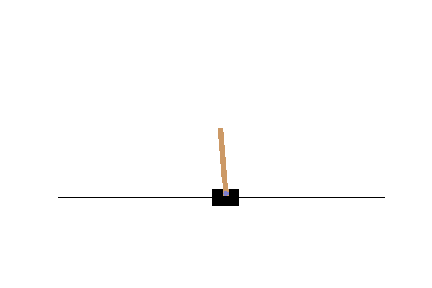
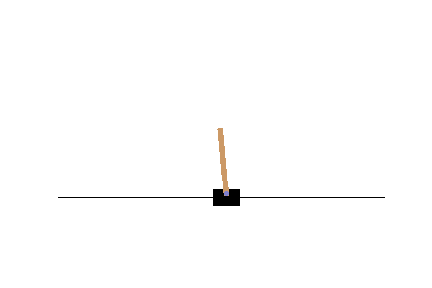
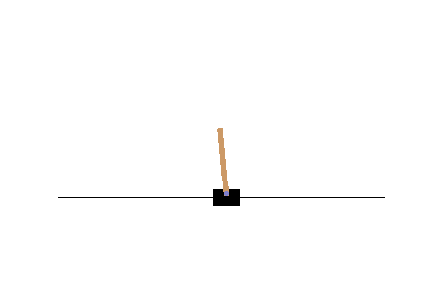
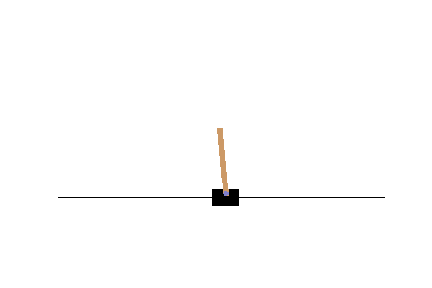
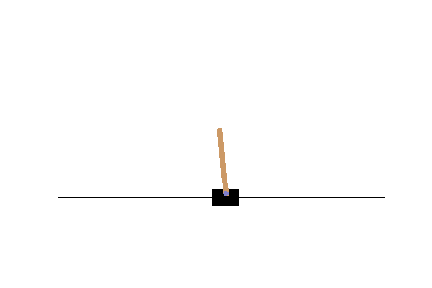
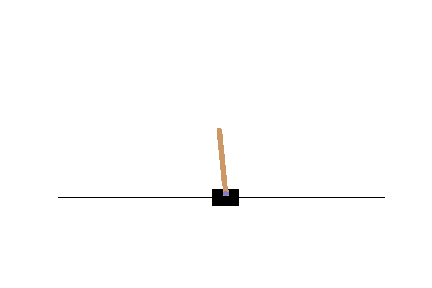
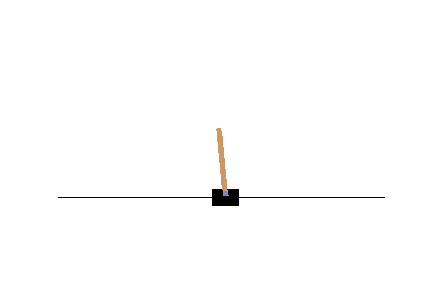
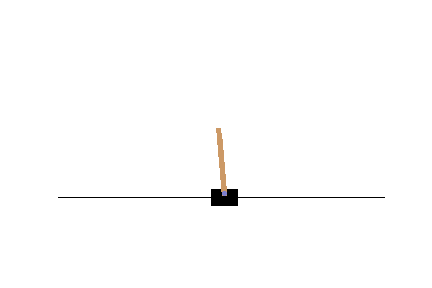
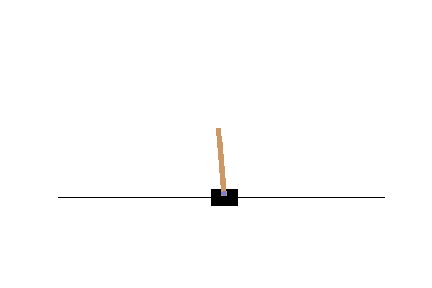
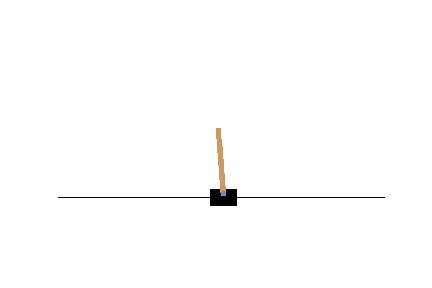
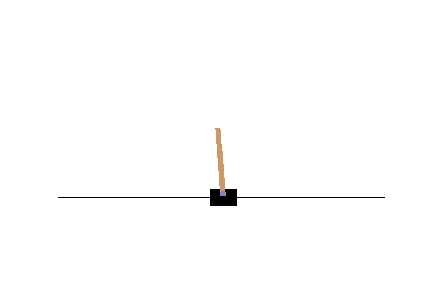
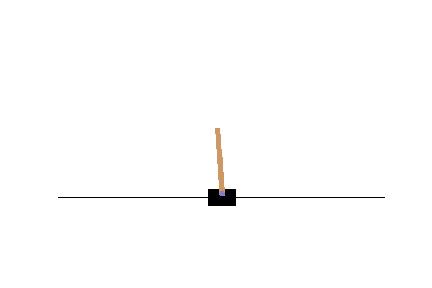
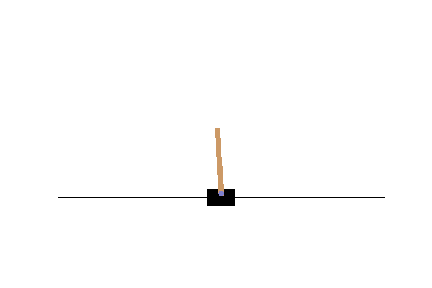
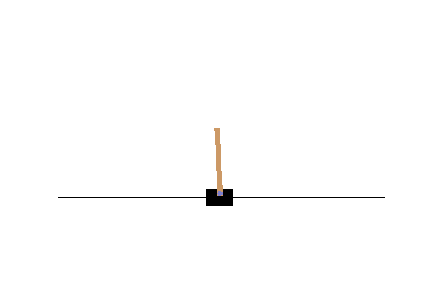
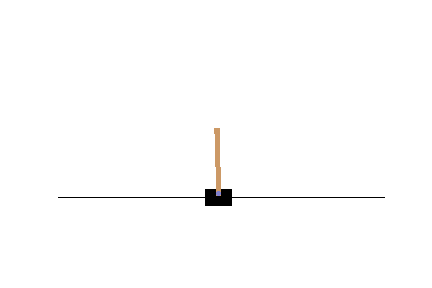
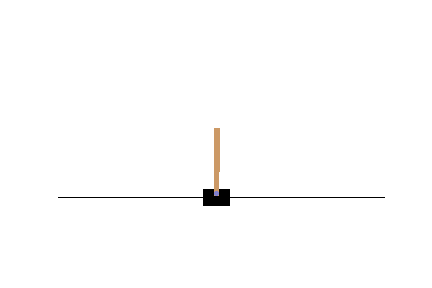
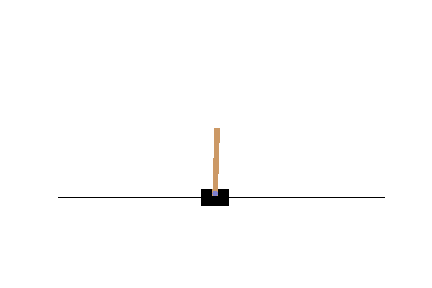
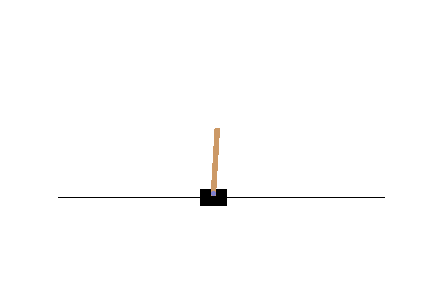
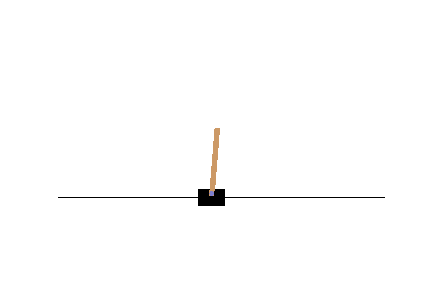
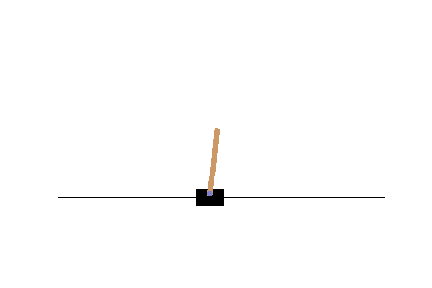
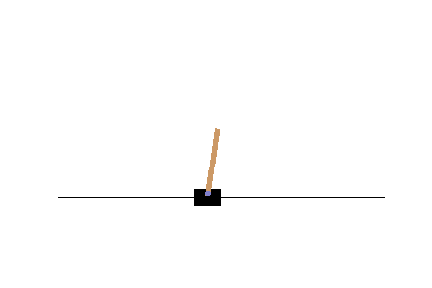
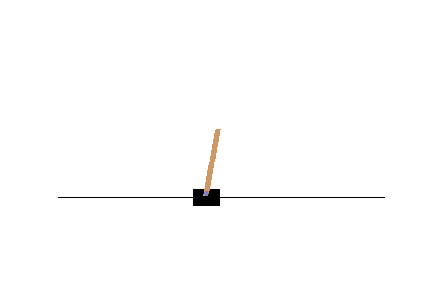
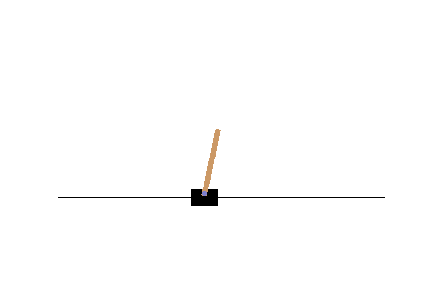

In [8]:
display_frames_as_gif(best)